# Project 2: Exploring the GitHub Dataset with Colaboratory
---


In this project, you will explore one of BigQuery's public datasets on GitHub and learn to make visualizations in order to answer your questions. This project is due on **Monday, November 1st, 11:59PM**. It is worth 50 points, for 15% of your overall grade. After completing this project, make sure to follow the submission instructions in the handout to submit on Gradescope.


### Notes (read carefully!):

* Be sure you read the instructions on each cell and understand what it is doing before running it.
* Don't forget that if you can always re-download the starter notebook from the course website if you need to.
* You may create new cells to use for testing, debugging, exploring, etc., and this is in fact encouraged! Just make sure that the final answer for each question is **in its own cell** and **clearly indicated**.
* Colab will not warn you about how many bytes your SQL query will consume.  **Be sure to check on the BigQuery UI first before running queries here!**
* See the assignment handout for submission instructions.
* Have fun!

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Name, SUNet ID*

# Overview

BigQuery has a massive dataset of GitHub files and statistics, including information about repositories, commits, and file contents.  In this project, we will be working with this dataset. Don't worry if you are not too familiar with Git and GitHub -- we will explain everything you need to know to complete this part of the assignment.

---
## Notes

**The GitHub dataset available on BigQuery is actually quite massive. *A single query on the "contents" table alone (it is 2.16TB!) can eat up your 1TB allowance for the month AND cut into about 10% of your GCloud credit for the class.***

To make this part of the project more manageable, we have subset the original data.  We have preserved almost all information in the original tables, but we kept only the information on the top 500,000 most "watched" GitHub repos between January 2016 and October 2018.

You can see the tables we will be working with [here](https://console.cloud.google.com/bigquery?project=cs145-fa21-326819&authuser=1&p=cs145-fa21-326819&d=project2&page=dataset). **Read through the schemas to get familiar with the data**.  Note that some of the tables are still quite large (the contents table is about 500GB), so you should exercise the usual caution when working with them.  Before running queries on this notebook, it's good practice to first set up query limits on your BigQuery account or see how many bytes will be billed on the web UI.

---

## *Make sure to use our subsetted dataset, not the original BigQuery dataset!*





## A Super Quick Primer on Git

If you are not very familiar with Git and GitHub, here are some high-level explanations that will give you enough context to get you through this part of the problem:

*  *GitHub*: GitHub is a source-control service provider.  GitHub allows you to collaborate on and keep track of source code in a fairly efficient way.

*  *commit*: A commit can be thought of as a change that is applied to some set of files. i.e., if some set of files is in some state A, you can make changes to A and *commit* your changes to the set of files so that it is now in state B.  A commit is identified by a *hash* of the information in your change (the author of the commit, who actually committed [i.e. applied] the changes to the set of files, the changes themselves, etc.)

* *parent commit*: The commit that came before your current commit.

*   *repo*:  A repo (short for repository) is GitHub's abstraction for a collection of files along with a history of commits on those files. If you have GitHub username "foo" and you make a repository called "data-rocks", your repo name will be "foo/data-rocks".  You can think of a repo's history in terms of its commits.  E.g., "foo/data-rocks" can have the set of "states" A->B->C->D, where each state change (A->B, B->C, C->D) was due to a commit.

*   *branch*:  To keep track of different commit histories, GitHub repos can have branches.  The 'main' branch (i.e. commit history) of the repo is called the 'master' branch.  Say on "foo/data-rocks" we have the commit history A->B->C->D on the master branch.  If someone else comes along and decides to add a cool new feature to "foo/data-rocks", they can create a branch called "cool-new-feature" that branches away from the master branch. All the code from the main branch will be there, but new code added to "cool-new-feature" will not be on the main branch.

*   *ref*: For the purpose of this assignment, you can think of the 'ref' field on the "files" table as referring to the branch in which a file lives in a repository at some point in time.



For the purposes of this question, you don't need to know about the following things in detail:


*   Commit trees
*   The encoding attribute on the commits table

If you want more clarifications about Git and GitHub in order to answer this question, be sure to post on Ed or come to Office Hours.  In many cases, a quick web search will also help answer your question.

# Section 1 | Understanding the Dataset (4 points)

---

Things to note:
* A file ID changes based on a file's contents; it is not assigned at a file's creation.
* Different repos can have files with the same paths.
* It is possible to have separate files with identical contents.
* A repo may have one file across multiple branches.



## Question 1: Schema Comprehension (4 points)

Each of the following parts is worth 1 point.



### a)  What is the primary key of `github_repo_files`? (1 point)

---
*lrepo_name, ref, path*

---

### b) What is the primary key in `github_repo_licenses`? What is the foreign key? (1 point)

---
*The primary key is lrepo_name and the foreign key is license.*

---


### c) If we were given authors and we wanted to know what programming languages they used in the repos that they contributed to, which tables should we use? (1 point)

---
*github_repo_commits & github_repo_languages*

---


### d) If we wanted to know whether using different licenses had an effect on a repo's watch count, which tables would we use? (1 point)

---
*github_repo_licenses & github_repos*

---

# Section 2 | Query Performance (8 points)
---


In this section, we'll look at some inefficient queries and think about how we can make them more efficient. For this section, we'll consider efficiency in terms of how many bytes are processed.

## Question 2: Optimizing Queries (8 points)


For the next three subquestions, consider the following query:

```
SELECT DISTINCT author.name
FROM `cs145-fa21-326819.project2.github_repo_commits` commits_1
WHERE (SELECT COUNT(*) 
       FROM `cs145-fa21-326819.project2.github_repo_commits` commits_2
       WHERE commits_1.author.name = commits_2.author.name) > 20

```

**NOTE:** We do **NOT** recommend running this unoptimized query in BigQuery, as it will run for a very long time (over 15 minutes if not longer). However, feel free to run an optimized version of this query after finishing part (c), which takes about 5 seconds to run.

### a) In one to two sentences, explain what this query does. (1 point)

---
*The query is to select all the authors who commits over 20 times, and output their name once.*

---

###b) Briefly explain why this query is inefficient (in terms of bytes that need to be processed) and how it can be improved to be more efficient. (1 point)

---
*The current query is inefficient because for each tuple in the outer table, we have to go through the table once to check. We could simply do the same thing by using group by author.name and HAVING COUNT() > 20.*

---

###c) Following from part (b), write a more efficient version of the query. (2 points)

---
```
SELECT DISTINCT author.name
FROM `cs145-fa21-326819.project2.github_repo_commits` commits_1
GROUP BY author.name
HAVING COUNT(*) > 20
```
---

For the next three subquestions, consider the following query:

```
SELECT id
FROM (
  SELECT files.id, files.mode, contents.size
  FROM
    `cs145-fa21-326819.project2.github_repo_files` files,
    `cs145-fa21-326819.project2.github_repo_readme_contents` contents
  WHERE files.id = contents.id
  )
WHERE mode = 33188 AND size > 1000  
LIMIT 10
```


###d) Briefly explain why this query is inefficient (in terms of bytes that need to be processed) without the query optimization and how it can be improved to be more efficient. (1 point)

---
*Only github_repo_files has the mode and only github_repo_readme_contents has the size so that it is a waste to use WHERE after they have been joined. Also, it cause more unnessary read and writes by using two FROM. The efficient way is to use several WHERE condition at the same time to reduce read and write time.*

---

###e) Following from part (d), write a more efficient version of the query. (2 points)

Hint: Think about the number of bytes processed by the unoptimized query. Can any operator be moved around to reduce this number?

---
```
SELECT files.id
  FROM
    `cs145-fa21-326819.project2.github_repo_files` files,
    `cs145-fa21-326819.project2.github_repo_readme_contents` contents
  WHERE files.id = contents.id AND mode = 33188 AND size > 1000  
LIMIT 10
```
---

###f) Run both the original query and your optimized query on BigQuery and pay attention to the number of bytes processed. How do they compare, and is it what you expect? Explain why this is happening in a few sentences. (1 point)

Hint: Look at the query plan under "Execution details" in the bottom panel of BigQuery. It may be especially helpful to look at stage "S00: Input".

---
*The number od bytes processed for two query are both 3.2GB. That is not what I expected... Maybe because the BigQuery have done some optimization for us before executing the query.*

---

To learn more about writing efficient SQL queries and how BigQuery optimizes queries, check out [Optimizing query computation](https://cloud.google.com/bigquery/docs/best-practices-performance-compute) and [Query plan and timeline](https://cloud.google.com/bigquery/query-plan-explanation).

# Section 3: Visualizing the Dataset (38 points)
---


In this section, you'll be answering questions about the dataset, similar to the first project. The difference is that instead of answering with a query, you will be answering with a visualization. Part of this assignment is for you to think about which data (specifically, which indicators) you should be using in order to answer a particular question, and about what type of chart / picture / visualization you should use to clearly convey your answer.

## General Instructions
* For each question, you will have at least two cells - a SQL cell where you run your query (and save the output to a data frame), and a visualization cell, where you construct your chart. For this project, make sure that **all data manipulation is to be done in SQL**. Please do not modify your data output using `pandas` or some other data library. Python should only be used for data visualization.
* Please make all charts clear and readable - this includes adding axes labels, clear tick marks, clear point markers / lines / color schemes (i.e. don't repeat colors across categories), legends, and so on. 

## Setting up BigQuery and Dependencies

Run the cell below (shift + enter) to authenticate your project. 

Note that you need to fill in the `project_id` variable with the Google Cloud project id you are using for this course.  You can see your project ID by going to https://console.cloud.google.com/cloud-resource-manager

In [2]:
# Run this cell to authenticate yourself to BigQuery.
from google.colab import auth
auth.authenticate_user() 
project_id = "proj2-330720"

## Visualization

For this project, we will be officially supporting the use of matplotlib (https://matplotlib.org/3.0.0/tutorials/index.html), but feel free to use another graphing library if you are more comfortable with it (eg. plotly, seaborn). 

If you are not familiar with matplotlib, please reference [this](https://matplotlib.org/3.0.0/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py) tutorial to get started.

In [3]:
# Add imports for any visualization libraries you may need
import matplotlib.pyplot as plt

%matplotlib inline

### How to Use BigQuery and visualize in Colab

Jupyter notebooks (what Colab notebooks are based on) have a concept called "magics".
If you write the following line at the top of a `Code` cell:


```
%%bigquery --project $project_id variable # this is the key line
SELECT ....
FROM ...
```

That "%%" converts the cell into a SQL cell. The resulting table that is generated is saved into `variable`. 

Then in a second cell, use the library of your choice to plot the variable. Here is an example using matplotlib:

```python
plt.figure()
plt.scatter(variable["x"], variable["y"])
plt.title("Plot Title")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
```

## Question 3: A First Look at Repo Features (6 points)


Let's get our feet wet with this data by creating the following plots:

1.   Language distribution across repos
2.   File size distribution
3.   The distribution of the length of commit messages


Note that you will not receive full credit if your charts are  poorly made (i.e. very unclear or unreadable).


### Hints
* Some of these plots will need at least one of their axes to be log-scaled in order to be readable
* For more readable plots, you can use [pandas.DataFrame.sample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html).  A sample size between 1,000 and 10,000 should give you more readable plots.
* Recommended Graph Types: bar chart or scatter plot.

##  Reminders
* Be careful with your queries!  Don't run `SELECT *` blindly on a table in this Colab notebook since you will not get a warning of how much data the query will consume.  Always how much data a query will consume on the BigQuery UI first -- you are also better off setting a query limit as we described earlier. 
* Don't forget to use the subsetted GitHub tables we provide [here](https://console.cloud.google.com/bigquery?project=cs145-fa21-326819&authuser=1&p=cs145-fa21-326819&d=project2&page=dataset), not the original ones on BigQuery. 




### a) Language distribution (2 points)
#### (x-axis: programming language, y-axis: # repos containing at least one file in that language)

To keep the chart readable, only keep the top 20 languages.

**Hint:** https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays (Lookup keyword UNNEST)


In [53]:
%%bigquery --project $project_id q3a
SELECT name language_name, COUNT(*) AS total_number
FROM `cs145-fa21-326819.project2.github_repo_files` files
JOIN (SELECT lrepo_name, name 
FROM `cs145-fa21-326819.project2.github_repo_languages`,
UNNEST(language)) language
ON files.lrepo_name = language.lrepo_name
GROUP BY name
ORDER BY total_number DESC
LIMIT 20

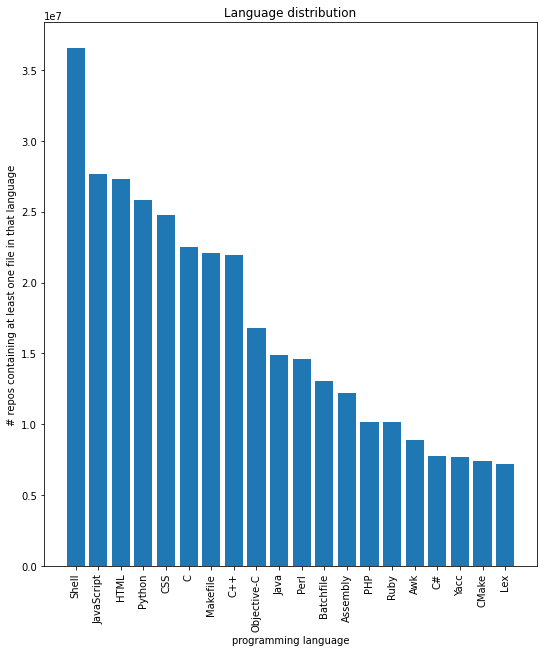

In [54]:
# YOUR PLOT CODE HERE
plt.figure(1, figsize = (30, 10))
plt.subplot(131)
plt.bar(q3a['language_name'], q3a['total_number'])
plt.xlabel('programming language')
plt.ylabel('# repos containing at least one file in that language')
plt.title('Language distribution')
plt.xticks(rotation = "vertical")
plt.show()


### b) File size distribution (2 points)
#### (x-axis: file size, y-axis: # files of that size) 

In [51]:
%%bigquery --project $project_id q3b
SELECT size, COUNT(*) num_files
FROM `cs145-fa21-326819.project2.github_repo_contents`
GROUP BY size
ORDER BY size
# YOUR QUERY HERE

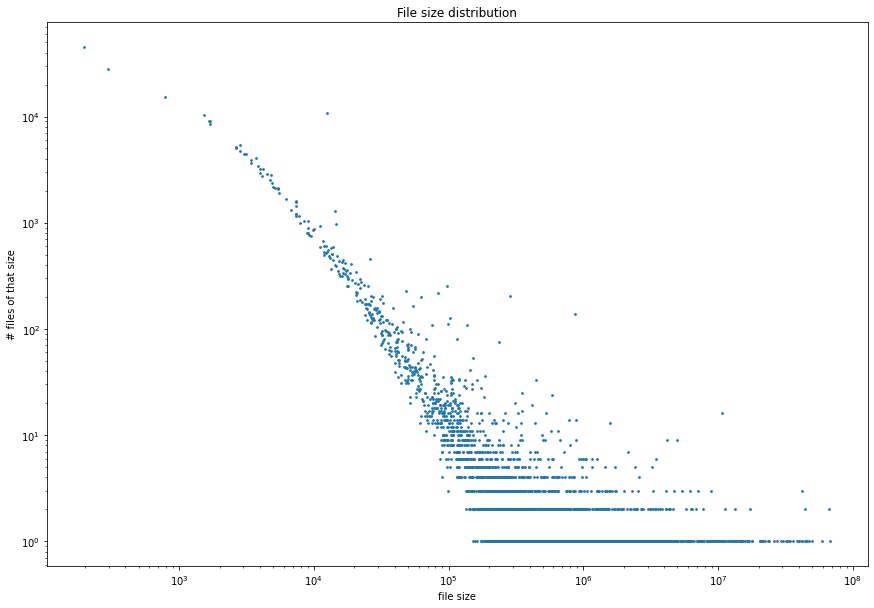

In [52]:
# YOUR PLOT CODE HERE
plt.figure(1, figsize = (50, 10))
plt.subplot(131)
q3b_1 = q3b.sample(3000)
plt.scatter(q3b_1['size'], q3b_1['num_files'], s = 3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('file size')
plt.ylabel('# files of that size')
plt.title('File size distribution')
plt.show()

### c) The distribution of the length of commit messages (2 points)
#### (x-axis: length of the commit message, y-axis: # commits with that length)

**Note**: The query for this plot may use ~30GB of data.

In [55]:
%%bigquery --project $project_id q3c
SELECT LENGTH(message) message_length, COUNT(*) num_commits
FROM `cs145-fa21-326819.project2.github_repo_commits`
GROUP BY message_length
ORDER BY message_length
# YOUR QUERY HERE

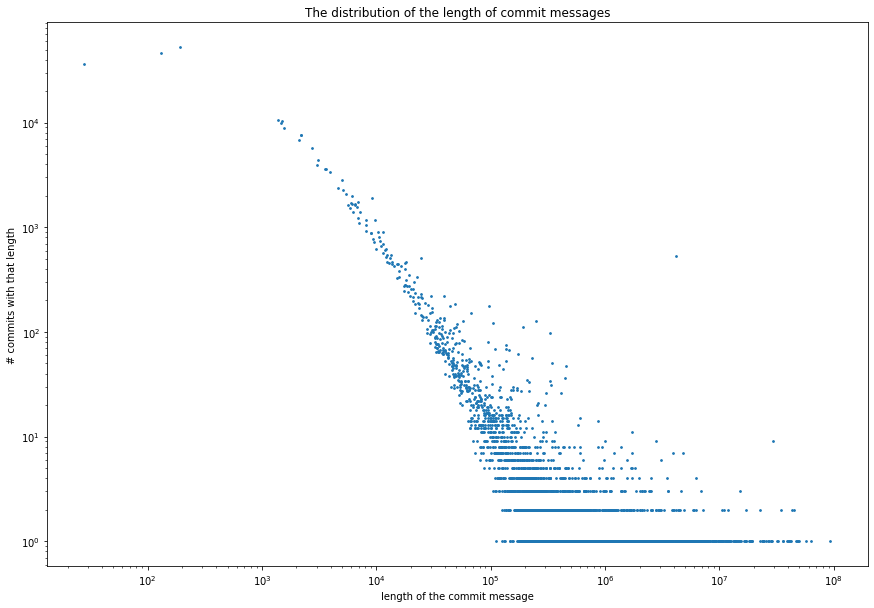

In [56]:
# YOUR PLOT CODE HERE
plt.figure(1, figsize = (50, 10))
plt.subplot(131)
q3b_1 = q3b.sample(3000)
plt.scatter(q3b_1['size'], q3b_1['num_files'], s = 3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('length of the commit message')
plt.ylabel('# commits with that length')
plt.title('The distribution of the length of commit messages')
plt.show()

## What Makes a Good Repo?
Given that we have some interesting data at our disposal, let's try to answer the question: what makes a good GitHub repo? For our purposes, a "good" repo is simply a repo with a high watch count; this refers to how many people are following the repo for updates.

To begin, let's see if any of the features we've already explored give us any good answers.

## Question 4: Using What We've Worked With (17 points)

Create plots for the following features in a repo and how they relate to that repo's watch count:

1.  Languages used
2.  Average file size in a repo
3.  Average message length of commits in a repo

### Hints
* Recommended Graph Types: bar chart or scatter plot.


### a) Languages used (4 points)

As in Q3a, please only keep the top 20 languages to keep the chart readable.

In [57]:
%%bigquery --project $project_id q4a
SELECT name AS language_used, SUM(repos.watch_count) num_of_watch
FROM `cs145-fa21-326819.project2.github_repos` repos 
JOIN (SELECT lrepo_name, name 
FROM `cs145-fa21-326819.project2.github_repo_languages`, 
UNNEST(language)) language
ON repos.lrepo_name = language.lrepo_name
GROUP BY name
ORDER BY num_of_watch DESC
LIMIT 20
# YOUR QUERY HERE

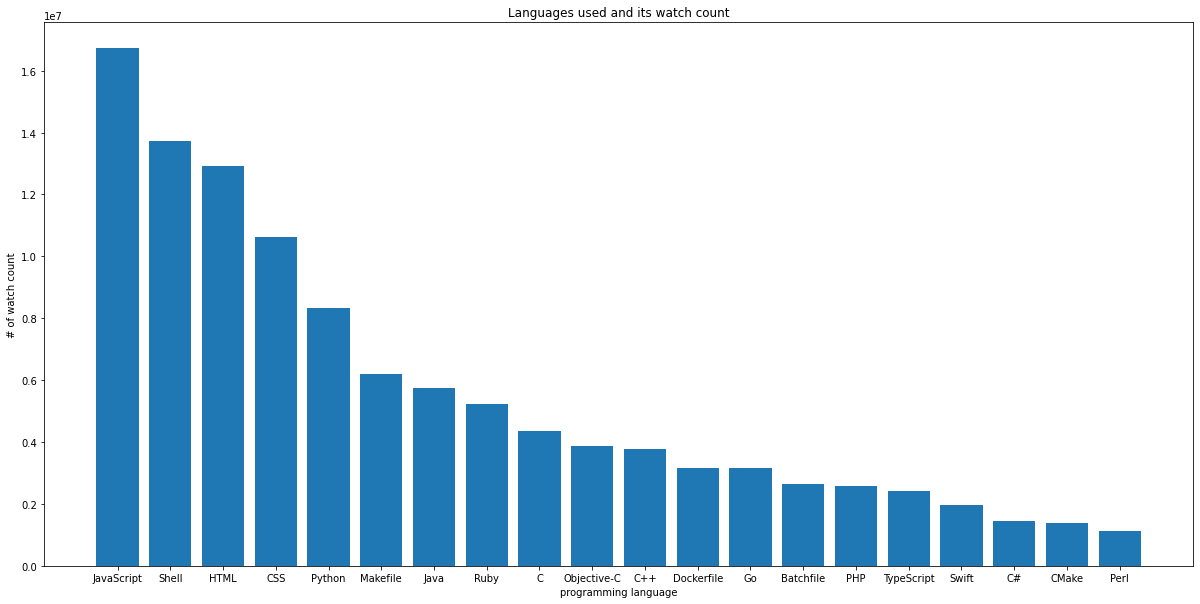

In [61]:
# YOUR PLOT CODE HERE
plt.figure(1, figsize = (70, 10))
plt.subplot(131)
plt.bar(q4a['language_used'], q4a['num_of_watch'])
plt.xlabel('programming language')
plt.ylabel('# of watch count')
plt.title('Languages used and its watch count')
plt.show()

### b) Average file size in a repo (4 points)
**Note:** For this question, you may use the `github_repo_readme_contents` table instead of the full contents table.


In [62]:
%%bigquery --project $project_id q4b

# YOUR QUERY HERE
SELECT s.average_size AS average_size, AVG(repos.watch_count) num_of_watch
FROM `cs145-fa21-326819.project2.github_repos` repos 
JOIN 

(SELECT files.lrepo_name, 
ROUND(AVG(contents.size)) average_size
FROM `cs145-fa21-326819.project2.github_repo_readme_contents` contents
JOIN `cs145-fa21-326819.project2.github_repo_files` files
ON contents.id = files.id
GROUP BY files.lrepo_name) s

ON repos.lrepo_name = s.lrepo_name
GROUP BY average_size
ORDER BY average_size

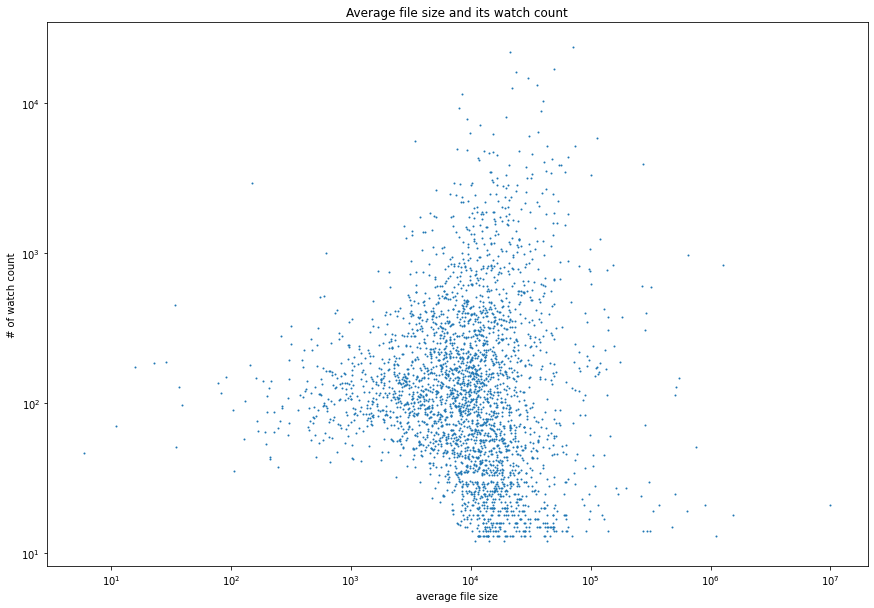

In [64]:
# YOUR PLOT CODE HERE
plt.figure(1, figsize = (50, 10))
plt.subplot(131)
q4b_1 = q4b.sample(3000)
plt.scatter(q4b_1['average_size'], q4b_1['num_of_watch'], s = 1)
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel('average file size')
plt.ylabel('# of watch count')
plt.title('Average file size and its watch count')
plt.show()

### c) Average message length of commits on a repo. (6 points)

First, make a plot of the average commit message length of repositories against the number of repositories with that average commit message length. 

Then, make a plot of how average commit message length of a repository correlates to its watch count. Round the average commit message length to the nearest integer.


In [65]:
%%bigquery --project $project_id q4c_avg_commit_length_count

# YOUR QUERY HER
SELECT average, COUNT(commit_1.lrepo_name) num_of_repos
FROM `cs145-fa21-326819.project2.github_repo_commits` commit_1
JOIN (SELECT commit_2.lrepo_name, ROUND(AVG(LENGTH(commit_2.message))) average
FROM `cs145-fa21-326819.project2.github_repo_commits` commit_2
GROUP BY commit_2.lrepo_name) average_com_len
ON commit_1.lrepo_name = average_com_len.lrepo_name
GROUP BY average
ORDER BY average

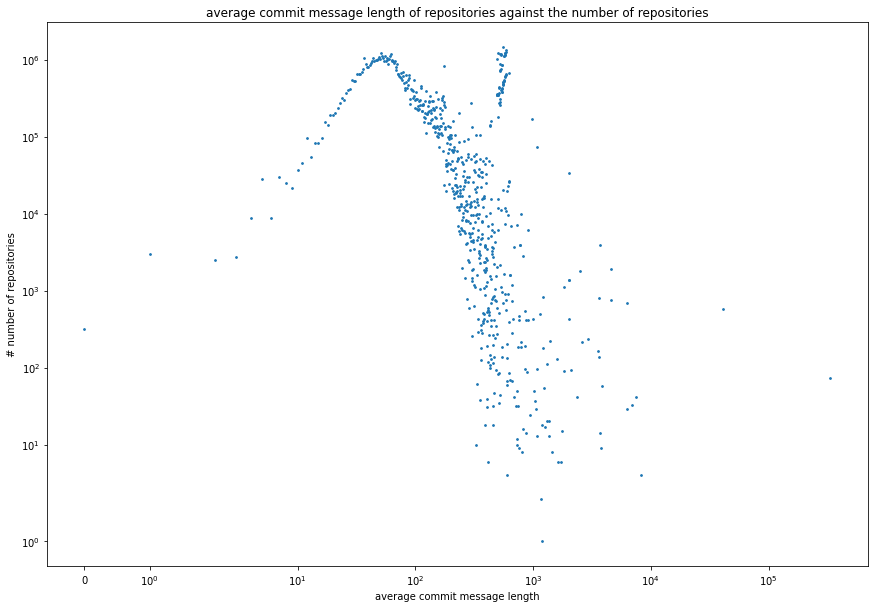

In [66]:
# YOUR PLOT CODE HERE
plt.figure(1, figsize = (50, 10))
plt.subplot(131)
plt.scatter(q4c_avg_commit_length_count['average'], 
            q4c_avg_commit_length_count['num_of_repos'], s = 3)
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel('average commit message length')
plt.ylabel('# number of repositories')
plt.title('average commit message length of repositories against the number of repositories')
plt.show()

In [67]:
%%bigquery --project $project_id q4c_msg_length_watch_count

# YOUR QUERY HERE
SELECT average, AVG(repositories.watch_count) watch_count
FROM `cs145-fa21-326819.project2.github_repos` repositories
JOIN (SELECT commit_2.lrepo_name, ROUND(AVG(LENGTH(commit_2.message))) average
FROM `cs145-fa21-326819.project2.github_repo_commits` commit_2
GROUP BY commit_2.lrepo_name) average_com_len
ON repositories.lrepo_name = average_com_len.lrepo_name
GROUP BY average
ORDER BY average

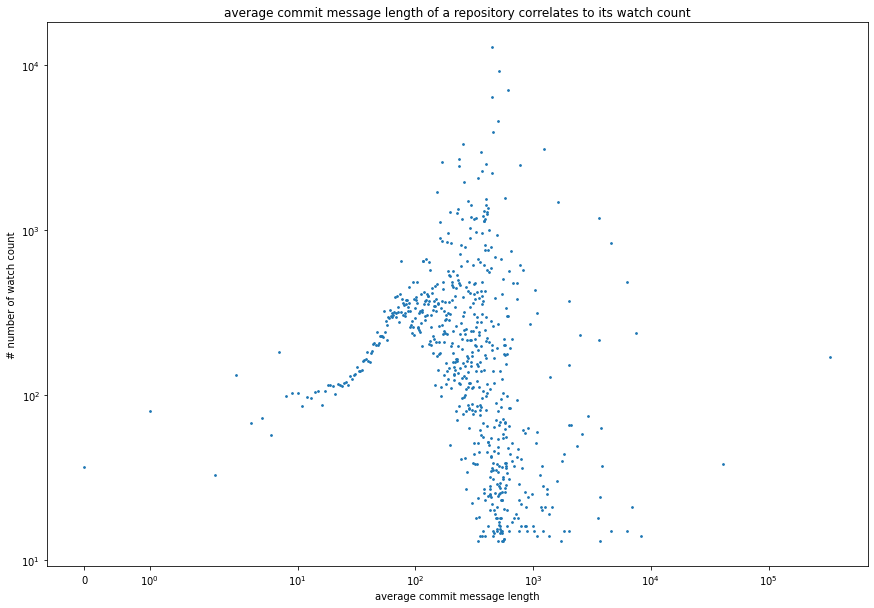

In [68]:
# YOUR PLOT CODE HERE
plt.figure(1, figsize = (50, 10))
plt.subplot(131)
plt.scatter(q4c_msg_length_watch_count['average'], 
            q4c_msg_length_watch_count['watch_count'], s = 3)
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel('average commit message length')
plt.ylabel('# number of watch count')
plt.title('average commit message length of a repository correlates to its watch count')
plt.show()

### d) Which, if any, of the features we inspected above have a high correlation to a repo having a high watch count? Does the answer make sense, or does it seem counterintuitive? Explain your answer in a small paragraph, no more than 200 words.  Be sure to cite the charts you generated. (3 points)

---
*I would say all of the three attributes have some correlation with a repo having a high watch count. First is the language used, we could see that JavaScript and Shell are very popular(with high watch count) in q4a. However, it might be caused by the larger number of users of that language in q3a. As for the average file size in q4b and average commit message length in q4c, they have a high watch count around 10^4B of file size and 10^2 in the message length. This makes sense because a moderate size of the file are most likely to be read and comprehended and the commit messaage length around 10^2 is proper for people to read through while still containing enough indformation.*

---

## What Do Others Have to Say?

At this point we have learned a couple of things about how certain features may or may not impact the popularity of a GitHub repo.  However, we really only looked at features of GitHub repos that we had initially explored when we were getting a feel for the dataset!  There has got to be more things we can inspect than that.

If you do a web search for "how to make my git repo popular," you will find that more than a couple of people suggest investing time in your `README` file.  The `README` usually gives an overview to a GitHub project and may include other information about the codebase such as whether its most recent build passed or how to begin contributing to that repo.  [Here](https://github.com/vuejs/vue/blob/dev/README.md) is an example `README` file for the popular web development framework Vue.js.


## IMPORTANT: Note about Contents Table

Note that the original `github_repo_contents` table is about half a TB!  In order to save you the pain of using up 500GB of your credits to subset this table into a workable size for this problem, we have done it for you. 

## ***For the rest of this question, be sure that you use the `github_repo_readme_contents` table ***

## Question 5: Analyzing README Features (15 points)

Analyze the following features of a repo's `README` file and how they relate to the watch count of a repository, generating an informative plot for each feature:

1.   Having or not having a `README` file
2.   The length of the `README` file

Consider a `README` file to be any file with the path beginning with "README", not case-sensitive.

You may ignore README files with length 0.

### a) Having or not having a `README` file (6 points)

**Note**: Exclude all empty repos.


In [69]:
%%bigquery --project $project_id q5a

# YOUR QUERY HERE
WITH
  readme_repository AS (
  SELECT
    DISTINCT "1" AS whether_readme,
    repository.lrepo_name AS repository_name,
    watch_count
  FROM
    `cs145-fa21-326819.project2.github_repo_files` files,
    `cs145-fa21-326819.project2.github_repos` repository,
    `cs145-fa21-326819.project2.github_repo_readme_contents` contents
  WHERE
    files.id = contents.id
    AND files.lrepo_name = repository.lrepo_name
    AND LENGTH(contents.content) > 0
    AND (path LIKE "README%"
      OR path LIKE "readme%"))
SELECT
  whether_readme,
  repository_name,
  watch_count
FROM
  readme_repository
UNION ALL
SELECT
  DISTINCT "0" AS whether_readme,
  repository.lrepo_name AS repository_name,
  watch_count
FROM
  `cs145-fa21-326819.project2.github_repo_files` files,
  `cs145-fa21-326819.project2.github_repos` repository
WHERE
  files.lrepo_name = repository.lrepo_name
  AND repository.lrepo_name NOT IN (
  SELECT
    repository_name
  FROM
    readme_repository)

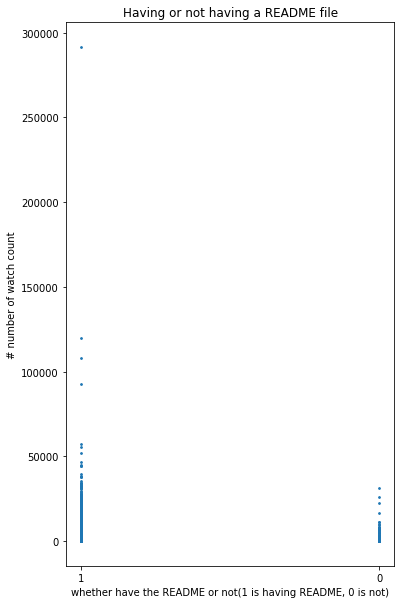

In [71]:
# YOUR PLOT CODE HERE
plt.figure(1, figsize = (20, 10))
plt.subplot(131)

plt.scatter(q5a['whether_readme'], q5a['watch_count'], s = 3)

plt.xlabel('whether have the README or not(1 is having README, 0 is not)')
plt.ylabel('# number of watch count')
plt.title('Having or not having a README file')
plt.show()

### b) The length of the `README` file (6 points)

**Note**: If a project has multiple `README` files, you can just take the average length of those files. Ignore repos without `README` files.

In [72]:
%%bigquery --project $project_id q5b

# YOUR QUERY HERE
SELECT
  DISTINCT repository.lrepo_name AS repository_name,
  watch_count,
  AVG(LENGTH(contents.content)) AS length
FROM
  `cs145-fa21-326819.project2.github_repo_files` files,
  `cs145-fa21-326819.project2.github_repo_readme_contents` contents,
  `cs145-fa21-326819.project2.github_repos` repository
WHERE
  files.lrepo_name = repository.lrepo_name
  AND files.id = contents.id
  AND LENGTH(contents.content) > 0
  AND (path LIKE "README%"
      OR path LIKE "readme%")
GROUP BY
  repository_name,
  watch_count
ORDER BY
  watch_count
  

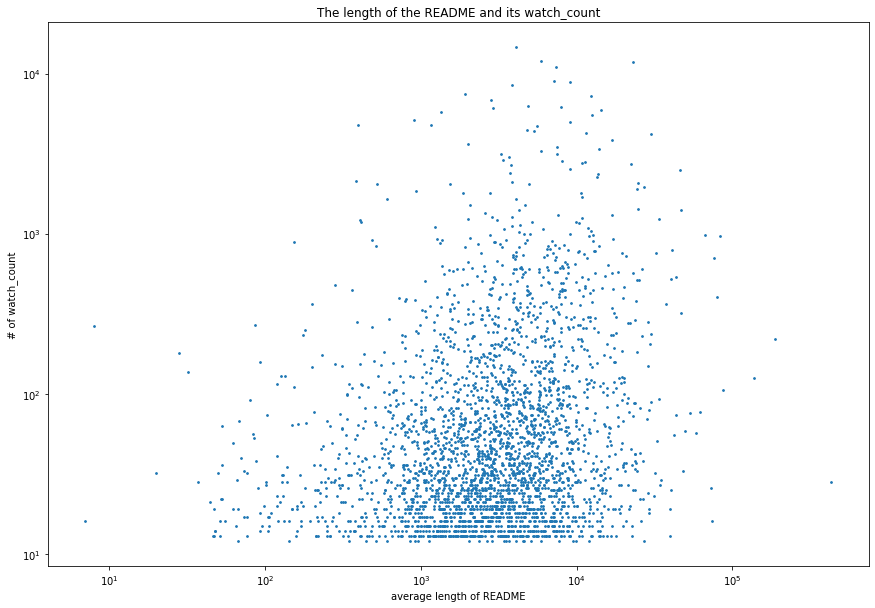

In [73]:
# YOUR PLOT CODE HERE
plt.figure(1, figsize = (50, 10))
plt.subplot(131)
q5b_1 = q5b.sample(3000)
plt.scatter(q5b_1['length'], 
            q5b_1['watch_count'], s = 3)
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel('average length of README')
plt.ylabel('# of watch_count')
plt.title('The length of the README and its watch_count')
plt.show()

### c) Would you say that a "good" `README` is correlated with a popular repository, based on the features you studied?  Why or why not?  If you were to analyze more in-depth features on the `README` file for correlation with repo popularity what would they be? (3 points)

---
*I would say that a good README file indeed has some relation with being a popular repository or not. From graph q5a, we could tell that having a README file has long ditribution than not having one, especially in the greater watch count area. Then, in the graph q5b, though there is not a clear linear pattern. we could not argue that a "good" README file has nothting to do with the number of watch count, because writing a longer README file does not guarantee that it is a good "README" file. So there might be a lot outlier there, we should further investigate. If I were to analyze more in-depth features on the README file for correlation with repo popularity, I would investigate the language the README use. Because more people reads English so that the English version off README could be read and watch by more people. Also, I would look into the structure of the README, for example, a good structured README states clearly what the function and usage and the potential bugs in the repo so that more people would find it useful and watch.*

---

## Question 6 (Extra Credit): What other features might correlate with a highly watched repo? (3 possible points)

We studied only a handful of features that could correlate with a highly watched repo.  Can you find a few more that seem especially promising?  Back your proposed features with data and charts.


---

*I would propose that the license would be one attribute to a highly watched repo. From the graph I draw from q6, we could see that, indeed, the average watch count for some license are higher than other. For example, repo that uses cc0-1.0, has almost twice watch count than the second most licence, apache-2.0.*


---



In [74]:
# YOUR QUERIES HERE
%%bigquery --project $project_id q6
SELECT
  license,
  ROUND(AVG(watch_count)) AS average_watch
FROM
  `cs145-fa21-326819.project2.github_repo_licenses` licenses,
  `cs145-fa21-326819.project2.github_repos` repos
WHERE
  licenses.lrepo_name = repos.lrepo_name
GROUP BY
  license
ORDER BY
  average_watch DESC

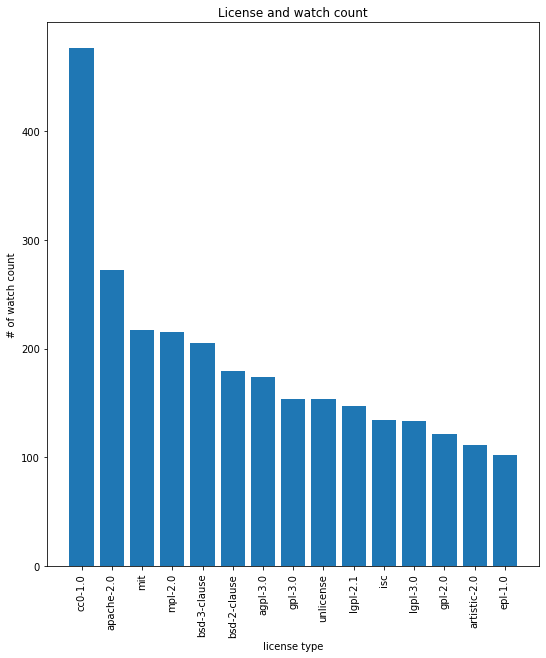

In [75]:
# YOUR PLOT CODE HERE
plt.figure(1, figsize = (30, 10))
plt.subplot(131)
plt.bar(q6['license'], q6['average_watch'])
plt.xlabel('license type')
plt.ylabel('# of watch count')
plt.title('License and watch count')
plt.xticks(rotation = "vertical")
plt.show()